# Gaussian graphical model

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import networkx as nx
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import os
from time import gmtime, strftime
import scipy as sp
import cvxopt
from sklearn.linear_model import lars_path
%matplotlib inline 

## Generate smooth graph signal

In [2]:
from latent_signal_network import latent_signal_network as lsn 

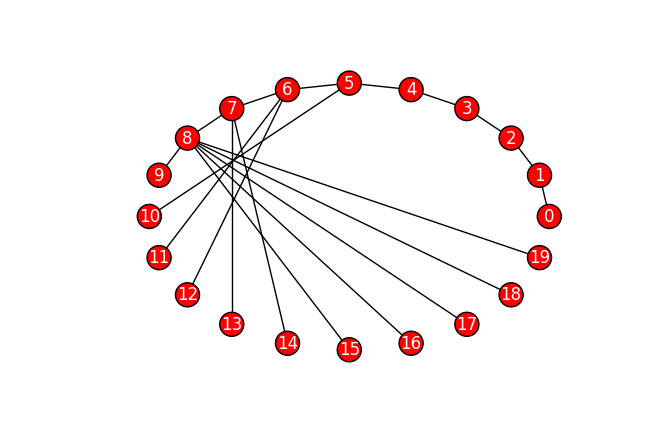

In [3]:
savefigure = False
seed = 1000
choice = 'tree'
d = 12
if choice == 'newman':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'partition':
    size = [10, 10]
    prob = [0.9, 0.1]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['cutoff_freq'] = 12
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'grid':
    size = [4, 5]
    prob = 0.6
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'binomial':
    size = 20
    prob = 0.18

    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
    
elif choice == 'tree':
    size = 20
    gamma = 3
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'gamma': gamma ,'model': choice}
    option['cutoff_freq'] = 10
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
    
elif choice == 'balanced_tree':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['r'] = 2
    option['h'] = 3
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)    

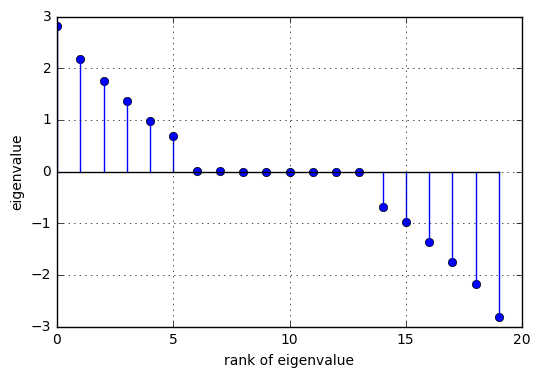

In [4]:
#Plot the eigenvalue of adjacency matrix
adjMat =  nx.adjacency_matrix(G0).todense()
Sigma, U = np.linalg.eigh(adjMat)
index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

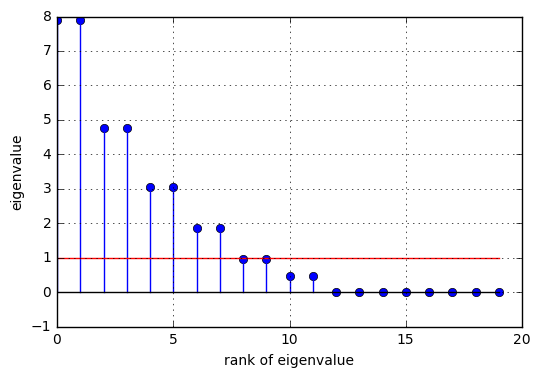

In [5]:
#Plot the eigenvalue of adjacency matrix
adjMat =  nx.adjacency_matrix(G0).todense()
Sigma, U = np.linalg.eigh(np.dot(adjMat, adjMat))
index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

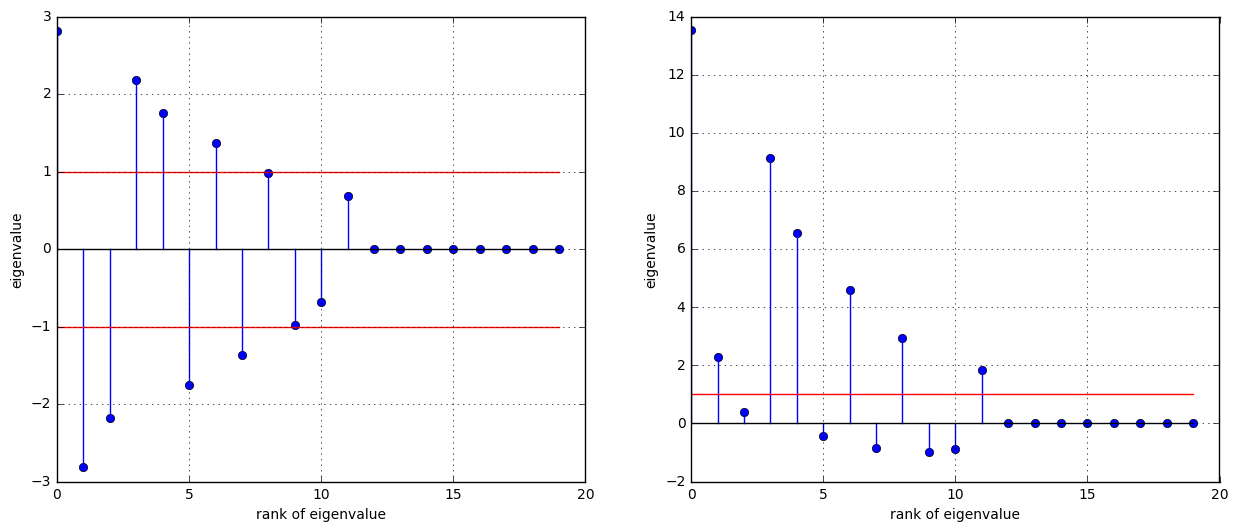

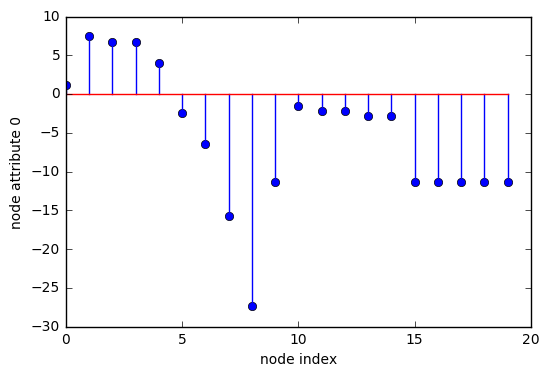

In [6]:
Tmax = 1
option_sig = {}
option_sig['mat'] = 'adjacency_matrix'
choice2 = 'polynomial'

if choice2 == 'l1_threshold':
    option_sig['method'] = choice2
    option_sig['threshold'] = 0.5
elif choice2 == 'polynomial':
    option_sig['method'] = choice2
    option_sig['coeffs'] = [1e-2,2,1]
elif choice2 == 'rescale':
    option_sig['method'] = choice2
    option_sig['weights'] = np.random.rand((len(G),))
    
G0_node, X0, _= LSN.smooth_gsignal_filter(G0, option_sig, sigma=10, seed=10, add_noise=False, show_plot=True, save_fig=savefigure)
#G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=10, alpha=0.2, seed=10, add_noise=False, overwrite=True)
fig1 = plt.figure(1)
plt.stem(np.arange(X0.shape[0]),X0[:,0])
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_node_fea0.eps"
if savefigure : fig1.savefig(filename)

In [7]:
if choice == 'newman' or choice == 'tree':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
elif choice == 'grid':
    pos=dict(zip(G0.nodes(), [np.asarray(u) for u in G0.nodes()]))
else:
    pos=nx.nx_pydot.graphviz_layout(G0)
    
pos_coordinate = np.array([[pos[key][0], pos[key][1]] for key in pos])
X0_2, nodeIdx = LSN.get_node_attributes(G0_node)
edge_list = LSN.get_edgelist(G0_node)

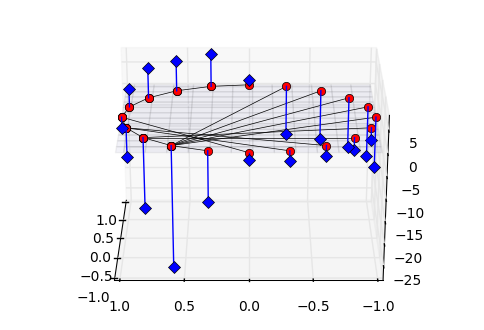

In [8]:
view_angle = [25, 180] #[25, 180]
LSN.plot_node_3d(pos_coordinate, edge_list, X0_2, view_angle=view_angle, nodeIdx=nodeIdx, save_fig=savefigure)

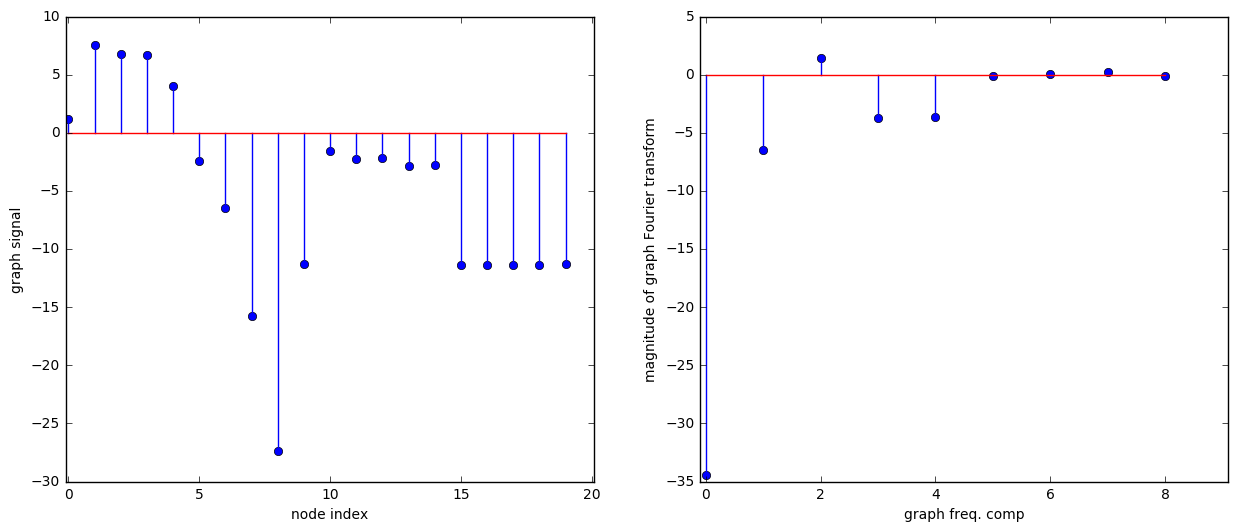

In [9]:
GFx0 = LSN.graph_fourier_transform(X0, show_fig=True, save_fig = savefigure)

##  Sparse covariance estimation via gLasso

In [10]:
from sklearn import preprocessing
#X0 += np.random.randn(X0.shape[0], X0.shape[1])
X0 -= np.mean(X0, axis=0)
X0 /= X0.std(axis=0)

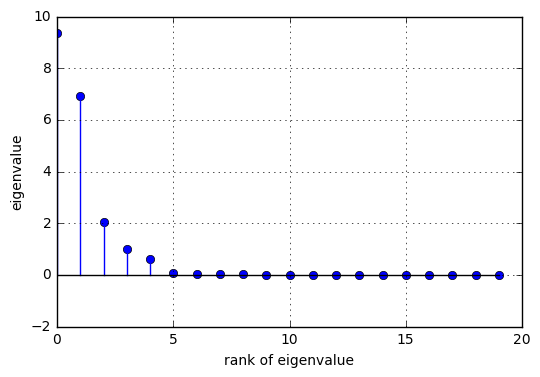

In [11]:
Sigma0, U0 = np.linalg.eigh(np.cov(X0))
index_sig0 = np.argsort(Sigma0)
Sigma0 = Sigma0[index_sig0[::-1]]
U0 = U0[:,index_sig0[::-1]]
fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma0)), Sigma0, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_cov.eps"
if savefigure : fig3.savefig(filename)

In [12]:
from Gaussian_network import sparse_inv_cov_glasso 
from sklearn.covariance import graph_lasso, GraphLasso, GraphLassoCV, ledoit_wolf

The covariance matrix of smooth graph signal. We can compare it with the adjacency matrix of the graph. We can see that those nodes that are connected in the graph have strong correlation compared with those nodes that are not in the same neighborhood.

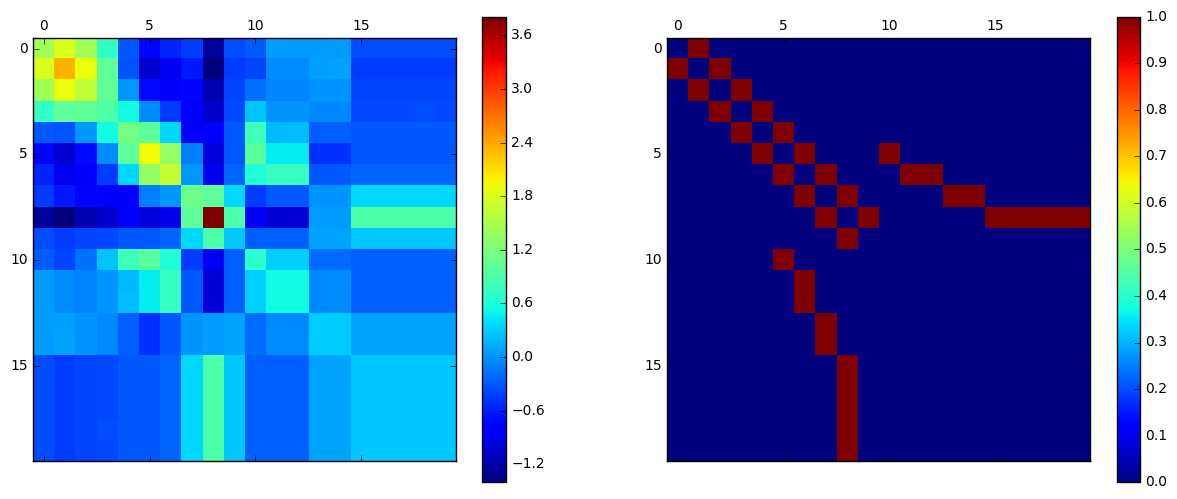

In [13]:
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat.eps"
if savefigure : fig2.savefig(filename)

Use my own version of graph lasso

In [14]:
init_sigma = 1
covariance, precision = sparse_inv_cov_glasso(X0, alpha=0.4, max_iter = 100)

The algorithm did not coverge. Try increasing the max number of iterations.


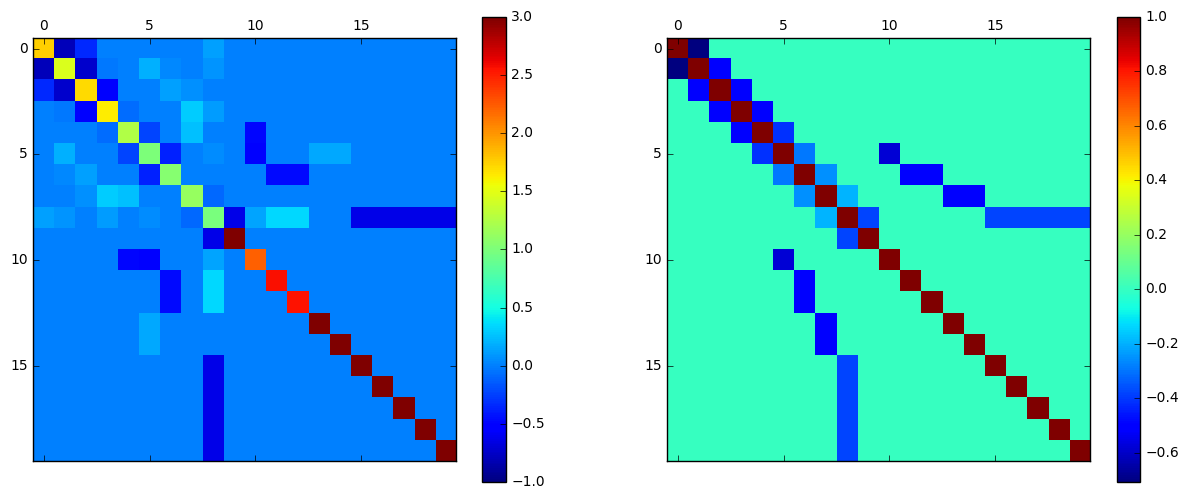

In [15]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(precision, vmin=-1, vmax=3)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)

Laplacian = nx.normalized_laplacian_matrix(G0).todense()
cax = ax.matshow(Laplacian)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)


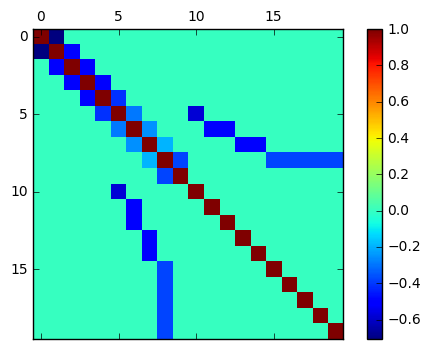

In [16]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(Laplacian)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_laplacian.eps"
if savefigure : fig2.savefig(filename)

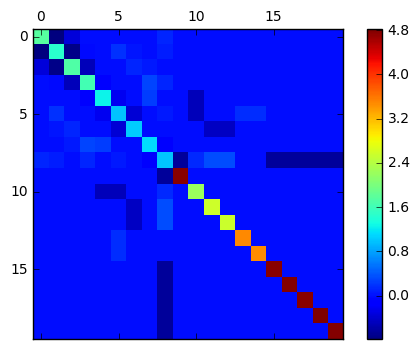

In [17]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(precision)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision.eps"
if savefigure : fig2.savefig(filename)

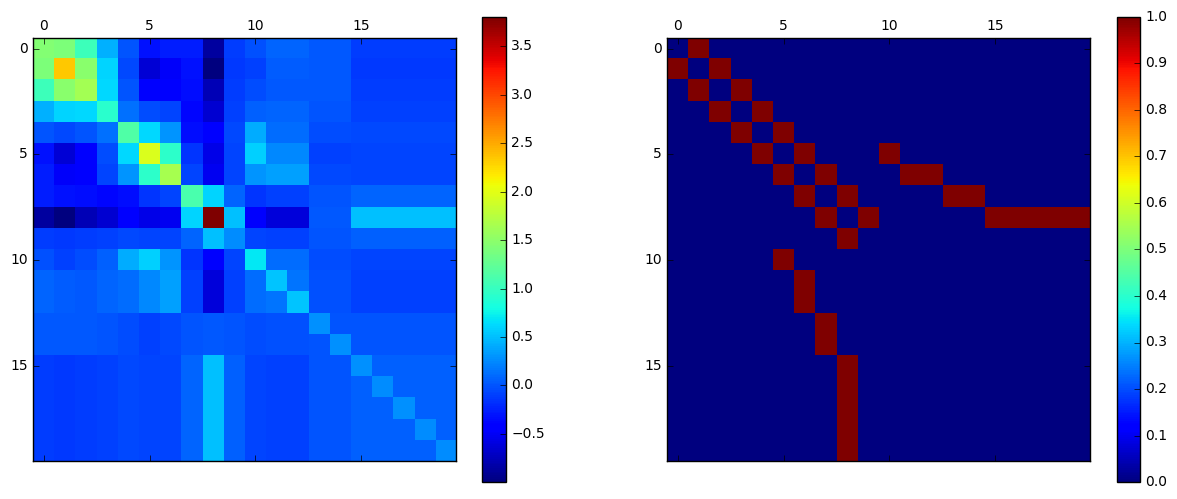

In [18]:
# plot the reconstructed covariance matrix 
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(covariance)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_recon_adjmat.eps"
if savefigure : fig2.savefig(filename)

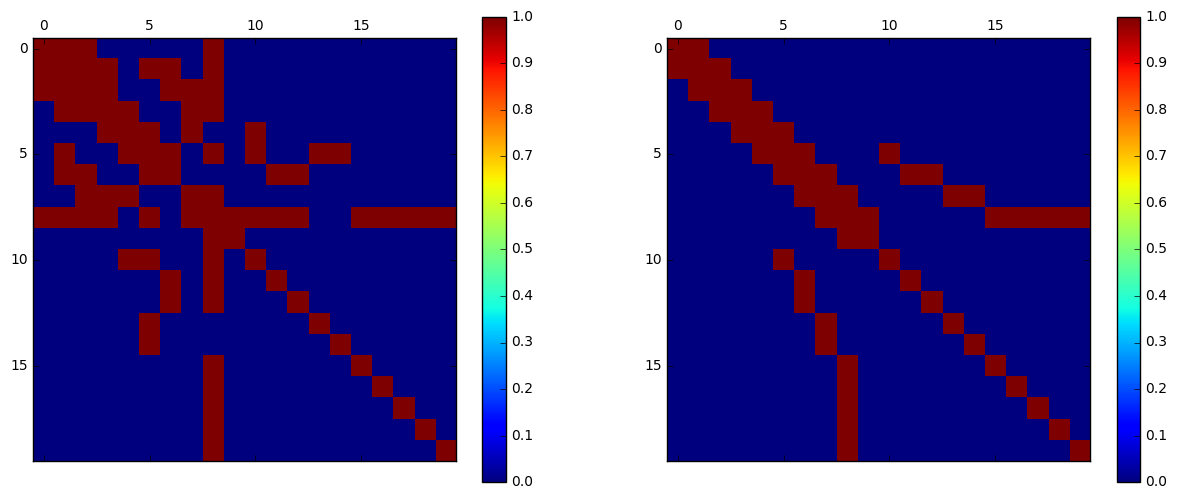

In [19]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(sp.sign(abs(precision)), vmin=0, vmax =1)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
Laplacian = nx.normalized_laplacian_matrix(G0).todense()
cax = ax.matshow(sp.sign(abs(Laplacian)), vmin=0, vmax =1)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_bin.eps"
if savefigure : fig2.savefig(filename)

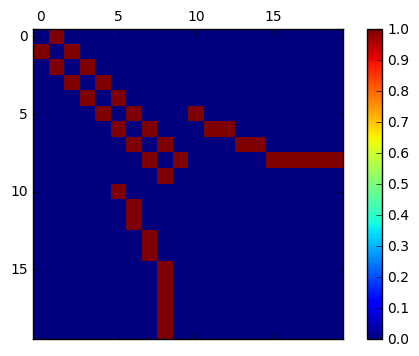

In [20]:
# the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat, vmin=0, vmax =1)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_adjMat.eps"
if savefigure : fig2.savefig(filename)

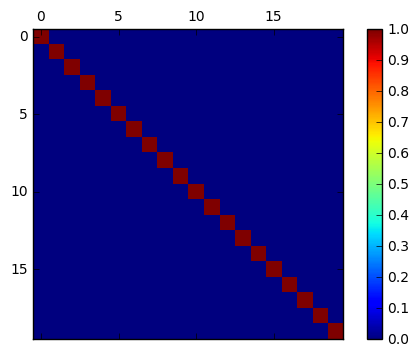

In [21]:
# the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
Laplacian = nx.normalized_laplacian_matrix(G0).todense()
cax = ax.matshow(Laplacian, vmin=0, vmax =1)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_Laplacian.eps"
if savefigure : fig2.savefig(filename)

Use pre-built package GraphLasso 

In [22]:
glasso = GraphLasso(alpha=0.5, mode='lars')
glasso.fit(X0.T)
covariance = glasso.covariance_
precision= glasso.precision_

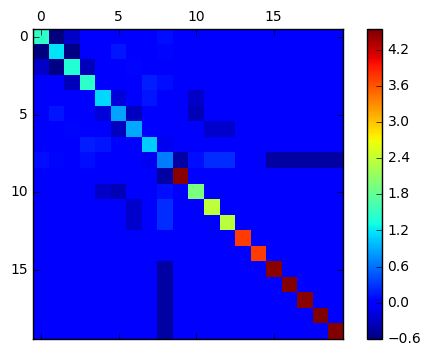

In [23]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(precision)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()

Use pre-built package graph_lasso, implemented as glasso R-package 

In [24]:
#covariance, precision = graph_lasso(emp_cov=np.cov(X0), alpha=0.5, cov_init=np.cov(X0), mode='lars', max_iter=100)

In [25]:
#fig2= plt.figure(2)
#ax = fig2.add_subplot(111)
#cax = ax.matshow(precision)
#fig2.colorbar(cax)
##cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
#plt.show()

##  Hacking using the transformed adjacency matrix to learn a sparse precision matrix 

In [40]:
from Gaussian_network import sparse_inv_cov_glasso_adjmat 
lambda_d = 0.5
emp_cov_hack = np.asarray(nx.adjacency_matrix(G0).todense()) + lambda_d*np.eye(len(G0))

In [41]:
emp_cov_hack.shape

(20, 20)

In [44]:
covariance_hack, precision_hack = sparse_inv_cov_glasso_adjmat(emp_cov_hack, alpha=0.9, max_iter = 100)

/home/tianpei/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/least_angle.py:290: RuntimeWarning: invalid value encountered in absolute
  diag = max(np.sqrt(np.abs(c - v)), eps)


OverflowError: int too large to convert to float

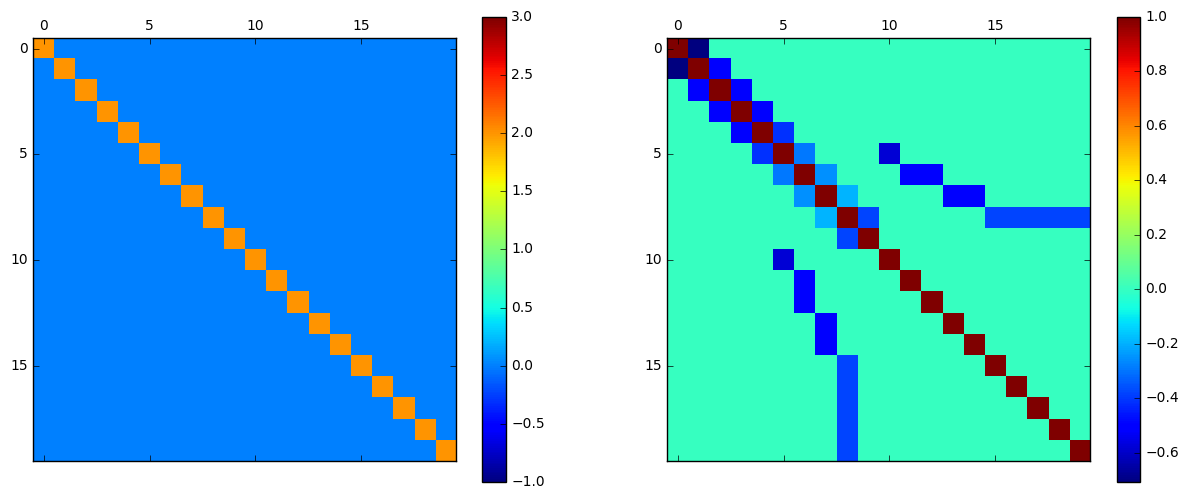

In [43]:

# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(precision_hack, vmin=-1, vmax=3)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)

Laplacian = nx.normalized_laplacian_matrix(G0).todense()
cax = ax.matshow(Laplacian)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian.eps"
if savefigure : fig2.savefig(filename)